In [19]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

In [37]:
scratch_data = json.load(open('/mmdetection/data/scratch/annotations/clean_old_scratch.json'))
print(len(scratch_data['images']), len(scratch_data['annotations']))

23473 114285


In [6]:
print(scratch_data['images'][0])
print(scratch_data['annotations'][0])

{'id': 2021, 'license': 4, 'coco_url': 'coco.org', 'flickr_url': 'flickr.org', 'scalabel_url': 'https://s3.amazonaws.com/mc-imt/vehicle/2019Y7149/vehicle_additional_docs/21749/medium/15559750008971833159462424792505.jpg', 'width': 700, 'height': 525, 'file_name': 'https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7149_vehicle_additional_docs_21749_medium_15559750008971833159462424792505.jpg', 'date_captured': '2013-12-15 02:41:52'}
{'id': 48, 'category_id': 0, 'iscrowd': 0, 'segmentation': [[247.23426807813627, 552.5388470287706, 241.8845312109123, 567.4310481580877, 245.70577183035797, 573.9225204452259, 269.3974636709213, 576.5954796222829, 287.7394186442605, 569.3403047131284, 298.43889237870843, 572.7769665122017, 301.495884874265, 578.8865874883319, 291.94278332565085, 587.6691676415189, 267.1047192992539, 593.778788617649, 264.8119749275864, 587.6691676415189, 254.87674931702762, 587.6691676415189, 249.90913651174824, 591.8695320626083, 240.35603496313396, 598.7428556607549, 228.51018

In [ ]:
value_list = []

for ann in scratch_data['annotations']:
    for img in scratch_data['images']:
        if img['id'] == ann['image_id']:
            img_w = img['width']
            img_h = img['height']
            break
            
    value = (ann['id'], ann['image_id'], img_w, img_h, ann['bbox'][2], ann['bbox'][3], ann['bbox'][0], ann['bbox'][1])
    value_list.append(value)

In [9]:
    
column_names = ['ann_id', 'img_id', 'img_width', 'img_height', 'box_width', 'box_height', 'xmin', 'ymin']
box_df = pd.DataFrame(value_list, columns = column_names)

box_df.to_csv('./output_data/gt_box_info.csv', index=False)

In [225]:
box_df.to_csv('./output_data/gt_box_info.csv', index=False)

In [11]:
box_df.describe()

,ann_id,img_id,img_width,img_height,box_width,box_height,xmin,ymin
count,114285.000000,114285.000000,114285.000000,114285.000000,114285.000000,114285.000000,114285.000000,114285.000000
mean,179309.909787,35561.124583,1559.091631,1183.264164,128.426487,64.405903,715.192714,632.011170
std,74942.384958,14454.881645,1232.582523,891.356810,232.316206,108.998063,705.791882,575.523447
min,48.000000,19.000000,200.000000,113.000000,1.195392,0.881026,0.000000,0.000000
25%,133222.000000,27317.000000,700.000000,720.000000,22.749092,13.277973,287.134159,310.912692
50%,178628.000000,35433.000000,1280.000000,960.000000,54.364641,29.707923,510.892244,461.900441
75%,220707.000000,42827.000000,1600.000000,1152.000000,134.265829,69.414586,857.205624,690.878746
max,354496.000000,69306.000000,17510.000000,13132.000000,5151.886665,2547.129282,13248.717517,11777.406340


In [60]:
import math
math.sqrt(17500)

132.28756555322954

In [117]:
box_df = pd.read_csv('./output_data/gt_box_info.csv')
box_df = box_df[box_df['img_width']*box_df['img_height']<=0.5e8]
print(box_df)
print(box_df.describe())

        ann_id  img_id  img_width  img_height   box_width  box_height  \
0           48      19        600         800  124.954568   96.974548   
1           90      43        700         525   51.724490   54.296118   
2           95      47        700         340  172.735602   83.031269   
3           96      47        700         340   97.824353   35.234958   
4           97      47        700         340  114.098491   22.535913   
...        ...     ...        ...         ...         ...         ...   
114280  354492   69306        389         800   10.063371   27.731015   
114281  354493   69306        389         800   27.686104   21.420991   
114282  354494   69306        389         800    6.752708    5.397415   
114283  354495   69306        389         800   10.965352   28.532995   
114284  354496   69306        389         800    9.803678    8.053712   

              xmin        ymin  
0       227.745941  540.717141  
1       451.317370  231.818974  
2       127.159570  148.

In [118]:
min_dimension = 480
max_dimension = 1024
# function from Tensorflow Object Detection API to resize image
def _compute_new_static_size(width, height, min_dimension, max_dimension):
    orig_height = height
    orig_width = width
    orig_min_dim = min(orig_height, orig_width)
  
    # Calculates the larger of the possible sizes
    large_scale_factor = min_dimension / float(orig_min_dim)
      # Scaling orig_(height|width) by large_scale_factor will make the smaller
      # dimension equal to min_dimension, save for floating point rounding errors.
      # For reasonably-sized images, taking the nearest integer will reliably
      # eliminate this error.
    large_height = int(round(orig_height * large_scale_factor))
    large_width = int(round(orig_width * large_scale_factor))
    large_size = [large_height, large_width]
    if max_dimension:
    # Calculates the smaller of the possible sizes, use that if the larger
    # is too big.
        orig_max_dim = max(orig_height, orig_width)
        small_scale_factor = max_dimension / float(orig_max_dim)
    # Scaling orig_(height|width) by small_scale_factor will make the larger
    # dimension equal to max_dimension, save for floating point rounding
    # errors. For reasonably-sized images, taking the nearest integer will
    # reliably eliminate this error.
        small_height = int(round(orig_height * small_scale_factor))
        small_width = int(round(orig_width * small_scale_factor))
        small_size = [small_height, small_width]
        new_size = large_size
    if max(large_size) > max_dimension:
        new_size = small_size
    else:
        new_size = large_size
    
    return new_size[1], new_size[0]

box_df['new_img_w'], box_df['new_img_h'] = np.vectorize(_compute_new_static_size)(box_df['img_width'], box_df['img_height'], min_dimension, max_dimension)
box_df['new_b_w'] = box_df['new_img_w']*box_df['box_width']/box_df['img_width']
box_df['new_b_h'] = box_df['new_img_h']*box_df['box_height']/box_df['img_height']
box_df['new_box_ar'] = box_df['new_b_h']/box_df['new_b_w']
box_df['new_box_area'] = box_df['new_b_w']*box_df['new_b_h']
print(box_df)
box_df.describe()

        ann_id  img_id  img_width  img_height   box_width  box_height  \
0           48      19        600         800  124.954568   96.974548   
1           90      43        700         525   51.724490   54.296118   
2           95      47        700         340  172.735602   83.031269   
3           96      47        700         340   97.824353   35.234958   
4           97      47        700         340  114.098491   22.535913   
...        ...     ...        ...         ...         ...         ...   
114280  354492   69306        389         800   10.063371   27.731015   
114281  354493   69306        389         800   27.686104   21.420991   
114282  354494   69306        389         800    6.752708    5.397415   
114283  354495   69306        389         800   10.965352   28.532995   
114284  354496   69306        389         800    9.803678    8.053712   

              xmin        ymin  new_img_w  new_img_h     new_b_w     new_b_h  \
0       227.745941  540.717141        480  

,ann_id,img_id,img_width,img_height,box_width,box_height,xmin,ymin,new_img_w,new_img_h,new_b_w,new_b_h,new_box_ar,new_box_area
count,114252.000000,114252.000000,114252.000000,114252.000000,114252.000000,114252.000000,114252.000000,114252.000000,114252.000000,114252.000000,114252.000000,114252.000000,114252.000000,114252.000000
mean,179304.974241,35560.252101,1554.762718,1180.021628,128.218672,64.235145,713.156849,630.035651,645.840484,507.472963,57.009267,29.352353,2.774607,3663.112640
std,74943.769217,14455.098845,1205.344178,870.195511,231.349605,108.112030,693.986657,562.414900,102.140257,74.857113,80.533147,41.041010,3.578430,12037.623057
min,48.000000,19.000000,200.000000,113.000000,1.195392,0.881026,0.000000,0.000000,472.000000,480.000000,0.914660,0.469394,0.024091,3.713029
25%,133221.750000,27316.750000,700.000000,720.000000,22.744324,13.272395,287.068723,310.874867,640.000000,480.000000,12.201794,7.187073,1.000000,98.390676
50%,178616.500000,35430.500000,1280.000000,960.000000,54.346730,29.701657,510.790815,461.824127,640.000000,480.000000,27.525741,15.036130,1.769204,400.936433
75%,220711.250000,42828.000000,1600.000000,1152.000000,134.117647,69.340528,856.869158,690.417003,640.000000,480.000000,65.327210,33.660798,3.222222,1915.462065
max,354496.000000,69306.000000,5152.000000,4608.000000,5151.886665,2547.129282,5076.684547,3784.008504,1017.000000,1024.000000,986.588571,677.468490,169.573728,407348.289224


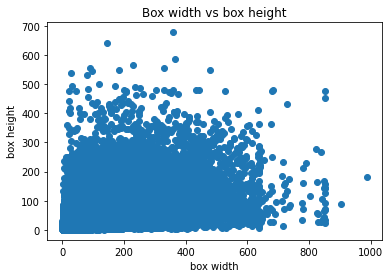

In [81]:
# aspectRatio = box_df['box_width']/box_df['box_height']
# boxArea = (box_df['box_width']*box_df['box_height'])/(box_df['img_width']*box_df['img_height'])
# plt.scatter(boxArea, aspectRatio)
# plt.xlabel('Box Area')
# plt.ylabel('Aspect Ratio')
# plt.title('Box area vs Aspect ratio')
# plt.show()

plt.scatter(box_df['new_b_w'], box_df['new_b_h'])
plt.xlabel('box width')
plt.ylabel('box height')
plt.title('Box width vs box height')
plt.show()

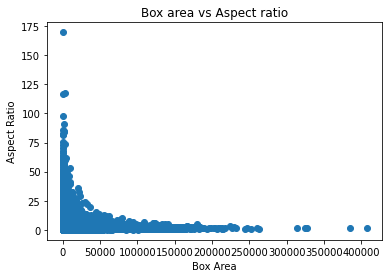

In [119]:
# box_df['box_area'] = box_df['new_b_w'] * box_df['new_b_h']
# norm_box_area = box_df['box_area']/(box_df['img_height']*box_df['img_width'])
plt.scatter(box_df['new_box_area'], box_df['new_box_ar'])
plt.xlabel('Box Area')
plt.ylabel('Aspect Ratio')
plt.title('Box area vs Aspect ratio')
plt.show()

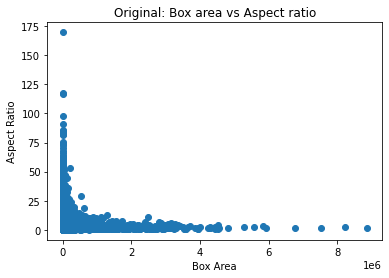

In [120]:
aspectRatio = box_df['box_width']/box_df['box_height']
boxArea = (box_df['box_width']*box_df['box_height'])
plt.scatter(boxArea, aspectRatio)
plt.xlabel('Box Area')
plt.ylabel('Aspect Ratio')
plt.title('Original: Box area vs Aspect ratio')
plt.show()

In [113]:
def count_base_size(width, height, input_array=[16,32,64,96,128,196,212,256,512]):
    result = {}
    for ele in input_array:
        result[str(ele)] = 0
    result['rest'] = 0
    
    for w,h in zip(width,height):
        done = False
        for inp in input_array:
            if w <= inp and h <= inp:
                result[str(inp)] += 1
                done = True
        if done == False:
            result['rest'] += 1
            
    return result

In [114]:
32/2

16.0

{'16': 31545, '32': 57941, '64': 82576, '96': 93747, '128': 100070, '196': 106938, '212': 107948, '256': 109942, '512': 113772, 'rest': 480} 114252


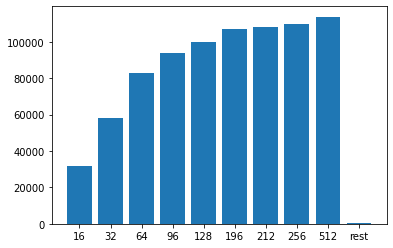

In [121]:
OD = count_base_size(box_df["new_b_w"].tolist(), box_df["new_b_h"].tolist())
# import collections
# OD = collections.OrderedDict(sorted(D.items()))
print(OD, OD['512'] + OD['rest'])
plt.bar(range(len(OD)), OD.values(), align='center')
plt.xticks(range(len(OD)), OD.keys()) 

plt.show()

In [122]:
base_anchor = 64*64
box_df['area_scale'] = np.sqrt((box_df['box_width']*box_df['box_height'])/base_anchor)

new_base_anchor = 64
box_df['new_area_scale'] = np.sqrt((box_df['new_b_w']*box_df['new_b_h'])/base_anchor)
box_df

,ann_id,img_id,img_width,img_height,box_width,box_height,xmin,ymin,new_img_w,new_img_h,new_b_w,new_b_h,new_box_ar,new_box_area,area_scale,new_area_scale
0,48,19,600,800,124.954568,96.974548,227.745941,540.717141,480,640,99.963655,77.579639,1.288530,7755.144190,1.719986,1.375989
1,90,43,700,525,51.724490,54.296118,451.317370,231.818974,640,480,47.290962,49.642165,0.952637,2347.625745,0.828042,0.757067
2,95,47,700,340,172.735602,83.031269,127.159570,148.221716,988,480,243.803963,117.220615,2.079873,28578.850463,1.871250,2.641450
3,96,47,700,340,97.824353,35.234958,163.138863,283.297906,988,480,138.072087,49.743470,2.775683,6868.184754,0.917340,1.294914
4,97,47,700,340,114.098491,22.535913,119.774202,273.185341,988,480,161.041870,31.815406,5.061757,5123.612496,0.792314,1.118428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114280,354492,69306,389,800,10.063371,27.731015,61.841041,195.414461,480,987,12.417528,34.213139,0.362946,424.842609,0.261021,0.322058
114281,354493,69306,389,800,27.686104,21.420991,0.168818,212.691889,480,987,34.162802,26.428148,1.292667,902.859593,0.380514,0.469494
114282,354494,69306,389,800,6.752708,5.397415,0.000000,205.101774,480,987,8.332391,6.659061,1.251286,55.485898,0.094330,0.116389
114283,354495,69306,389,800,10.965352,28.532995,140.380601,273.772277,480,987,13.530511,35.202582,0.384361,476.308925,0.276379,0.341008


## clustering box_ar

[KMeans(n_clusters=1, random_state=1), KMeans(n_clusters=2, random_state=1), KMeans(n_clusters=3, random_state=1), KMeans(n_clusters=4, random_state=1), KMeans(n_clusters=5, random_state=1)]
[1463002.3457494604, 686584.1154741284, 395484.37996501796, 255733.88912652878, 178418.55650691327]


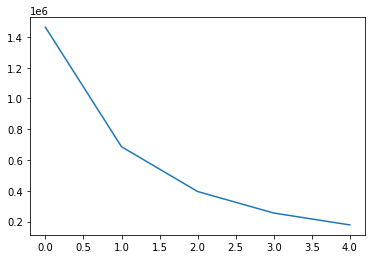

In [259]:
AR = (box_df['new_box_ar'].values).reshape(-1,1)
loss = []
label_list = []
from sklearn.cluster import KMeans
for i in range (1,6):
    K = KMeans(i, random_state = 1)
    labels = K.fit(AR)
    label_list.append(labels)
    loss.append(labels.inertia_)
    
print(label_list)
print(loss)
plt.plot(loss)

In [260]:
K = KMeans(5, random_state = 1)
labels = K.fit(AR)
print(labels.cluster_centers_)

[[ 1.30365657]
 [19.58878111]
 [ 9.06706005]
 [46.42710147]
 [ 3.98605494]]


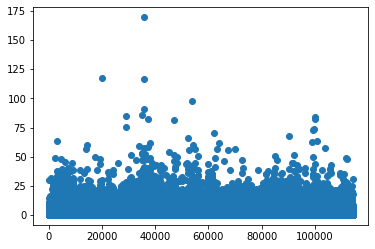

In [129]:
plt.plot(AR, 'o')

## clustering scale

[KMeans(n_clusters=1, random_state=1), KMeans(n_clusters=2, random_state=1), KMeans(n_clusters=3, random_state=1), KMeans(n_clusters=4, random_state=1), KMeans(n_clusters=5, random_state=1)]
[16555469046727.37, 5899101391867.338, 3071764093125.4688, 1850217679536.4236, 1255922852350.2031]


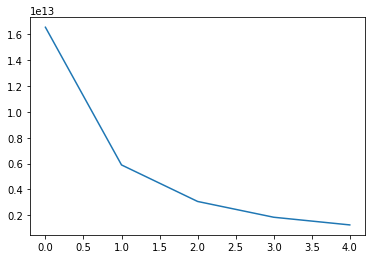

In [263]:
S = (box_df['new_box_area'].values).reshape(-1,1)
loss = []
label_list = []
from sklearn.cluster import KMeans
for i in range (1,6):
    K = KMeans(i, random_state = 1)
    labels = K.fit(S)
    label_list.append(labels)
    loss.append(labels.inertia_)
    
print(label_list)
print(loss)
plt.plot(loss)

In [266]:
K = KMeans(5, random_state = 1)
labels = K.fit(S)
print('mean loss(distance):', labels.inertia_)
center = np.array(labels.cluster_centers_)
print(center)
print(center/8)

mean loss(distance): 1255922852350.2034
[[   901.84445467]
 [ 75299.59377482]
 [149527.06186126]
 [ 12701.07042653]
 [ 36455.64582816]]
[[  112.73055683]
 [ 9412.44922185]
 [18690.88273266]
 [ 1587.63380332]
 [ 4556.95572852]]


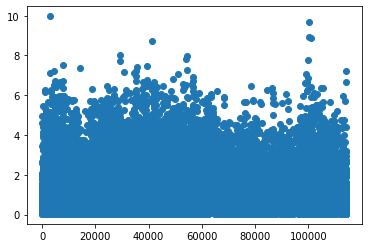

In [130]:
plt.plot(S, 'o')

## clustering both ar and scale

In [161]:
# print data.columns[[12,15]]
from sklearn.cluster import KMeans

def sweep_k_param(ar_scale):
    loss = {}
    centers = {}
    for k in range (2,6):
        
     
        # X = box_df.as_matrix(columns=box_df.columns[[12,15]])
        K = KMeans(k, random_state=0)
        labels = K.fit(ar_scale)
        loss[k] = labels.inertia_
        centers[k] = labels.cluster_centers_
        plt.subplot(2,2,k-1)
        plt.scatter(ar_scale[:, 0], ar_scale[:, 1], c=labels.labels_,s=50, cmap='viridis')

    return loss, centers

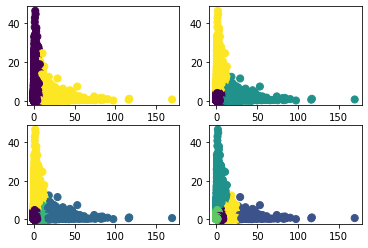

In [155]:
box_df['box_ar'] = box_df['box_width']/box_df['box_height']
ar_scale = box_df[['box_ar','area_scale']].values
loss, centers = sweep_k_param(ar_scale)
# print(labels.cluster_centers_)

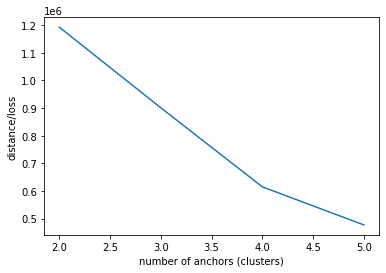

In [158]:
plt.plot(list(loss.keys()), list(loss.values()))
plt.xlabel('number of anchors (clusters)')
plt.ylabel('distance/loss')
plt.show()

In [160]:
print(centers[4])
print(loss[4])

ar = 

[[ 1.74086011  0.92239568]
 [24.97504726  1.26317699]
 [ 7.50254985  1.09918846]
 [ 2.42839606  8.71130285]]
615063.323567473


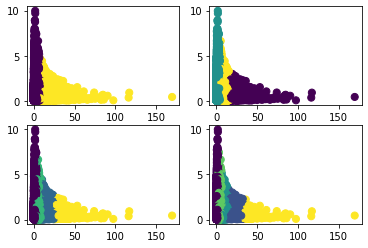

In [162]:
# print data.columns[[12,15]]
ar_scale = box_df[['new_box_ar','new_area_scale']].values
# X = box_df.as_matrix(columns=box_df.columns[[12,15]])

loss_v2, centers_v2 = sweep_k_param(ar_scale)

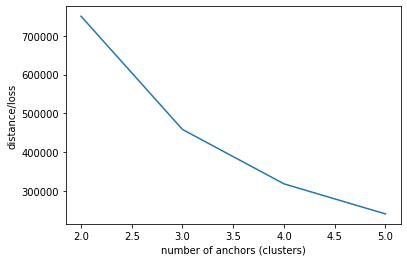

In [163]:
plt.plot(list(loss_v2.keys()), list(loss_v2.values()))
plt.xlabel('number of anchors (clusters)')
plt.ylabel('distance/loss')
plt.show()

In [166]:
picked_center = centers_v2[4]
# ar = picked_center[:,0]/picked_center[:,1]

scale = picked_center[:,1]*np.sqrt(ar)/64
print('aspect ratio: ',ar)
print('scale: ',scale)

aspect ratio:  [ 2.59028768 23.62001369  8.49998687 66.18857064]
scale:  [0.01447248 0.04379185 0.02779787 0.07051803]


In [177]:
picked_center = centers_v2[4]
print(picked_center)
ar = picked_center[:,0]
ar2 = picked_center[:,0]/picked_center[:,1]

area = np.power(picked_center[:,1],2)*(64)
scale = picked_center[:,1]*np.sqrt(ar)/64
print('aspect ratio: ',ar)
print('ar2: ', ar2)
print('area: ',area)
print('scale', scale)

[[ 1.49072311  0.57550485]
 [13.62113633  0.57667775]
 [ 5.18681417  0.61021437]
 [36.71737928  0.55473897]]
aspect ratio:  [ 1.49072311 13.62113633  5.18681417 36.71737928]
ar2:  [ 2.59028768 23.62001369  8.49998687 66.18857064]
area:  [21.19717296 21.28366251 23.8311413  19.69506055]
scale [0.01097912 0.03325523 0.02171465 0.0525224 ]


In [175]:
print(area/8)

[2.64964662 2.66045781 2.97889266 2.46188257]


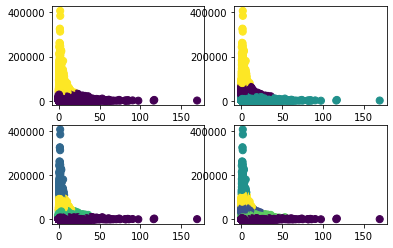

In [179]:
ar_scale = box_df[['new_box_ar','new_box_area']].values
loss_v3, centers_v3 = sweep_k_param(ar_scale)

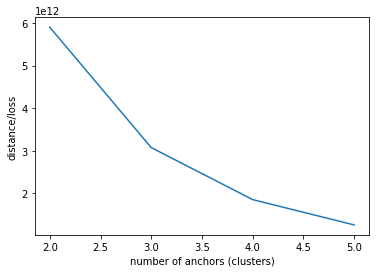

In [180]:
plt.plot(list(loss_v3.keys()), list(loss_v3.values()))
plt.xlabel('number of anchors (clusters)')
plt.ylabel('distance/loss')
plt.show()

In [186]:
picked_center_v3 = centers_v3[5]
print('centers: ', picked_center_v3)
area_ = picked_center_v3[:,1]
aspect_ratio = picked_center_v3[:,0]
print(aspect_ratio, area_)

centers:  [[2.76267655e+00 9.01205167e+02]
 [2.61600145e+00 3.64849206e+04]
 [1.83551670e+00 1.49527062e+05]
 [3.04136575e+00 1.26938652e+04]
 [2.25080659e+00 7.53776255e+04]]
[2.76267655 2.61600145 1.8355167  3.04136575 2.25080659] [   901.20516678  36484.92061809 149527.06186126  12693.86520245
  75377.62546838]


In [188]:
print(np.sqrt(area_)/8)`

[ 3.75250992 23.87628289 48.33591151 14.08338183 34.31873246]


ratios = [2.76267655, 2.61600145,  1.8355167, 3.04136575, 2.25080659],
strides = [3.75250992, 23.87628289, 48.33591151, 14.08338183, 34.31873246],
featmap_strides=[3.75250992, 23.87628289, 48.33591151, 14.08338183, 34.31873246]),



### w vs h

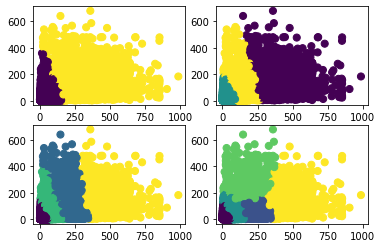

In [208]:
boxes = box_df[['new_b_w','new_b_h']].values
loss_v4, centers_v4 = sweep_k_param(boxes)

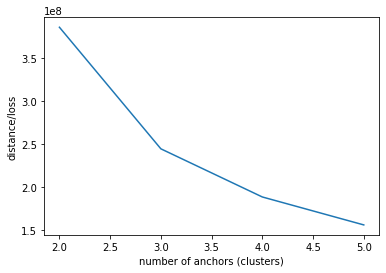

In [209]:
plt.plot(list(loss_v4.keys()), list(loss_v4.values()))
plt.xlabel('number of anchors (clusters)')
plt.ylabel('distance/loss')
plt.show()

In [213]:
#model v7
picked_center_v4 = centers_v4[5]
print('centers: ', picked_center_v4)
aspect_ratio = picked_center_v4[:,0]/picked_center_v4[:,1]
scale = picked_center_v4[:,0]/np.sqrt(aspect_ratio)

print('aspect_ratio',aspect_ratio)
print('scale',scale)
print(np.round(scale/8))

centers:  [[ 20.54092977  13.99055062]
 [215.02585105  61.84075074]
 [ 85.35920372  45.2123281 ]
 [180.77084748 204.97951743]
 [448.89043008 129.56214708]]
aspect_ratio [1.46820024 3.47708992 1.88796302 0.88189713 3.46467267]
scale [ 16.95225406 115.31417977  62.1231706  192.49498976 241.16220252]
[ 2. 14.  8. 24. 30.]


In [ ]:
print(np.sqrt(area_)/8)

In [267]:
#model v7
picked_center_v4 = centers_v4[3]
print('centers: ', picked_center_v4)
aspect_ratio = picked_center_v4[:,0]/picked_center_v4[:,1]
scale = picked_center_v4[:,0]/np.sqrt(aspect_ratio)

print('aspect_ratio',aspect_ratio)
print('scale',scale)
print(np.round(scale/8))

centers:  [[364.80619374 127.40062925]
 [ 26.37638551  16.96215555]
 [134.64750688  66.80117709]]
aspect_ratio [2.86345677 1.55501377 2.01564572]
scale [215.58417993  21.15184044  94.83992805]
[27.  3. 12.]


## Iou distance

A distance metric based on IoU is invariant to the size of boxes, unlike the Euclidean distance metric, which produces larger errors as the box sizes increase [1]. In addition, using an IoU distance metric leads to boxes of similar aspect ratios and sizes being clustered together, which results in anchor box estimates that fit the data.

In [189]:
import numpy as np


def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)


def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [198]:
box_df['shifted_box_w'] = box_df['new_b_w']/box_df['new_img_w']
box_df['shifted_box_h'] = box_df['new_b_h']/box_df['new_img_h']
boxes = box_df[['shifted_box_w', 'shifted_box_h']].values
print(boxes.shape)
clusters = kmeans(boxes, 4)
print(clusters)

(114252, 2)
[[0.08185686 0.05269608]
 [0.24980468 0.14824738]
 [0.0317292  0.02223528]
 [0.01132464 0.01004629]]


In [196]:
ratios = clusters[:,0]/clusters[:,1]
scales = 

[ 1  2  3 -1 -2 -3]


In [206]:
boxes = box_df[['new_b_w','new_b_h']].values
clusters = kmeans(boxes, 5)
print(clusters)
ar = clusters[:,0]/clusters[:,1]
print('aspect ratio: ',ar)
scale = clusters[:,0]/np.sqrt(ar)
print('scales: ', scale)

[[ 68.4886326   30.41846529]
 [  6.30249812   4.85641451]
 [ 25.33727493  18.82352941]
 [172.46422893  87.16228473]
 [ 17.64979502   7.54285714]]
aspect ratio:  [2.25154793 1.29776775 1.34604273 1.97865659 2.33993495]
scales:  [ 45.64339047   5.53240846  21.83888596 122.60659129  11.53819234]


In [207]:
scale/8

array([ 5.70542381,  0.69155106,  2.72986074, 15.32582391,  1.44227404])

In [202]:
boxes = box_df[['new_b_w','new_b_h']].values
out_dict = {}
for k in range (2,7):
    clusters = kmeans(boxes,k)
    out_dict[k] = clusters
    
print(out_dict)

{2: array([[13.29230769,  7.82026135],
       [70.99847435, 36.07158171]]), 3: array([[  9.21281777,   5.86787709],
       [115.62430939,  56.75138122],
       [ 31.50166852,  16.78379534]]), 4: array([[ 20.44728435,  11.20109815],
       [  7.3631681 ,   5.02614752],
       [ 52.33438374,  26.74360271],
       [156.39251049,  76.11170785]]), 5: array([[159.44179519,  77.24506258],
       [ 14.85082873,  16.94664453],
       [  7.57559153,   4.98287065],
       [ 53.28707719,  27.62529241],
       [ 29.52739617,   7.90665752]]), 6: array([[ 24.51042748,   6.54545455],
       [ 81.14917127,  36.89773507],
       [ 11.53054221,  13.25966851],
       [ 33.23072825,  19.76512138],
       [193.65288983,  98.58477003],
       [  6.7514388 ,   4.55153824]])}


In [268]:
print(out_dict)

[[ 10.38715577   7.65618739]
 [ 60.6897024   36.21085438]
 [156.77326969  75.60741249]
 [ 29.01272731  15.1160221 ]
 [434.56329183 214.1370168 ]]


In [217]:
picked_center = out_dict[5]
ar = picked_center[:,0]/picked_center[:,1]
print('aspect ratio: ',ar)
scale = picked_center[:,0]/np.sqrt(ar)
print('scales: ', scale)
print('scale/base_size: ', np.round(scale/8))

aspect ratio:  [2.06410339 0.87632857 1.52032675 1.92892355 3.73449794]
scales:  [110.9778872   15.8641645    6.14395578  38.36757862  15.27949635]
scale/base_size:  [14.  2.  1.  5.  2.]


In [223]:
#v8
picked_center = out_dict[3]
ar = picked_center[:,1]/picked_center[:,0]
print('aspect ratio: ',ar)
scale = picked_center[:,0]*np.sqrt(ar)
print('scales: ', scale)
print('scale/base_size: ', np.round(scale/8))

aspect ratio:  [0.63692534 0.49082569 0.53279068]
scales:  [ 7.35252897 81.00518045 22.99385912]
scale/base_size:  [ 1. 10.  3.]


In [226]:
box_df

,ann_id,img_id,img_width,img_height,box_width,box_height,xmin,ymin,new_img_w,new_img_h,new_b_w,new_b_h,new_box_ar,new_box_area,area_scale,new_area_scale,box_ar,shifted_box_w,shifted_box_h
0,48,19,600,800,124.954568,96.974548,227.745941,540.717141,480,640,99.963655,77.579639,1.288530,7755.144190,1.719986,1.375989,1.288530,0.208258,0.121218
1,90,43,700,525,51.724490,54.296118,451.317370,231.818974,640,480,47.290962,49.642165,0.952637,2347.625745,0.828042,0.757067,0.952637,0.073892,0.103421
2,95,47,700,340,172.735602,83.031269,127.159570,148.221716,988,480,243.803963,117.220615,2.079873,28578.850463,1.871250,2.641450,2.080368,0.246765,0.244210
3,96,47,700,340,97.824353,35.234958,163.138863,283.297906,988,480,138.072087,49.743470,2.775683,6868.184754,0.917340,1.294914,2.776344,0.139749,0.103632
4,97,47,700,340,114.098491,22.535913,119.774202,273.185341,988,480,161.041870,31.815406,5.061757,5123.612496,0.792314,1.118428,5.062963,0.162998,0.066282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114280,354492,69306,389,800,10.063371,27.731015,61.841041,195.414461,480,987,12.417528,34.213139,0.362946,424.842609,0.261021,0.322058,0.362892,0.025870,0.034664
114281,354493,69306,389,800,27.686104,21.420991,0.168818,212.691889,480,987,34.162802,26.428148,1.292667,902.859593,0.380514,0.469494,1.292475,0.071173,0.026776
114282,354494,69306,389,800,6.752708,5.397415,0.000000,205.101774,480,987,8.332391,6.659061,1.251286,55.485898,0.094330,0.116389,1.251100,0.017359,0.006747
114283,354495,69306,389,800,10.965352,28.532995,140.380601,273.772277,480,987,13.530511,35.202582,0.384361,476.308925,0.276379,0.341008,0.384304,0.028189,0.035666


In [245]:
box_df = pd.read_csv('./output_data/gt_box_info.csv')
print(box_df.shape)

(114252, 19)


In [248]:
origin_scratch = json.load(open('/mmdetection/data/scratch/annotations/clean_old_scratch.json'))
print(len(origin_scratch['annotations']))


114285


In [249]:
import copy
resize_box_data = copy.deepcopy(origin_scratch)

In [250]:
new_box_width = box_df[['new_b_w']].values
new_box_height = box_df[['new_b_h']].values
new_img_width = box_df[['new_img_w']].values
new_img_height = box_df[['new_img_h']].values

In [ ]:
resize_box_data['annotations'] = [ann for ann in origin_scratch['annotations'] if ann['id'] in list(box_df['ann_id'].values)]
print(len(resize_box_data['annotations']))
# for ann in resize_box_data['annotations']:
    

In [ ]:
print([ann['id'] for ann in resize_box_data['annotations']] == list(box_df['ann_id'].values))

In [238]:
len(list(box_df['ann_id'].values))

114252

In [244]:
id=[ann['id'] for ann in resize_box_data['annotations']]
len(id)

114285

In [ ]:
for i,ann in enumerate(resize_box_data['annotations']):
    ann['bbox'][2] = new_box_width[i]
    ann['bbox'][3] = new_box_height[i]
    


In [257]:
boxes = box_df[['box_width','box_height']].values
clusters = kmeans(boxes,5)
out_dict = clusters
    
print(out_dict)

[[ 10.38715577   7.65618739]
 [ 60.6897024   36.21085438]
 [156.77326969  75.60741249]
 [ 29.01272731  15.1160221 ]
 [434.56329183 214.1370168 ]]


In [258]:
ar = out_dict[:,1]/out_dict[:,0]
print('aspect ratio: ',ar)
scale = np.square(out_dict[:,1])*ar
print('scales: ', scale)
print('scale/base_size: ', np.round(scale/8))

aspect ratio:  [0.73708218 0.59665566 0.48227235 0.52101348 0.4927637 ]
scales:  [   43.20569735   782.35039853  2756.90061506   119.04851939
 22595.51302311]
scale/base_size:  [   5.   98.  345.   15. 2824.]
